# Conesa & Krueger (1999)
### John Ryan
This code was originally created for the solution to a problem set for Dean Corbae's computational economics course in Fall 2023. This was originally written in Julia, but is now translated to Python.

## Model

Each period a mass of workers is born, with constant population growth rate $n$ per period. Agents live for $N$ periods (adult years), with no stochastic mortality. Initial assets for each agent is $a_1 = 0$. Until age $j = J^R$, agents supply labor $\ell$ to a representative firm. At age $J^R$, agents retire ($\ell = 0$) and earn pension benefits / social security $b$, which is financed by a linear labor income tax  with constant rate $\theta$. We assume the government keeps a balanced budget. Agents get period utility 

$$ u(c, l) = \frac{[c^\gamma (1-\ell)^{1-\gamma}]^{1-\sigma}}{1-\sigma} $$

with a constant discount factor of $\beta$. Workers have productivity $e(z, j) = z*\eta_j$, where $\eta_j$ is a deterministic age-efficiency profile, and $z$ is a Markov process with an initial ergodic distribution at birth. There is a representative firm with production technology

$$ Y = K^\alpha L^{1-\alpha} $$

where $\alpha \in (0, 1)$ and labor depreciates at constant rate $\delta$. Labor and capital markets are assumed to be perfectly competitive. To solve the model computationally, we assume $z$ follows a 2 state Markov chain and take the following benchmark parameterization:

| Parameter | Value | Description |
| --- | --- | --- |
| $n$ | .011 | population growth rate |
| $N$ | 66 | length of adult life |
| $J^R$ | 46 | age of retirement |
| $\theta$ | .11 | income tax rate |
| $\gamma$ | .42 | Cobb-Douglas consumption weight |
| $\sigma$ | 2 | coefficient of relative risk aversion |
| $\beta$ | .97 | discount factor | 
| $\alpha$ | .36 | capital share |
| $\delta$ | .06 | capital depreciation |
| $z_H $ | 3.0 | high productivity value |
| $z_L$ | .5 | low productivity value |
| $\pi_H$ | .2037 | high productivity initial probability |
| $\pi_{HH}$ | .9261 | high productivity persistence probability |
| $\pi_{LL}$ | .9811 | low productivity persistence probability |
| $\eta_j$ | plotted below | age efficiency profile |



---

## Part 1

First we solve the dynamic programming problem for a retiree and worker. For now we assume the values $r=.05, w=1.05, b=.2$, but these will be solved for later. We start at the end of life, $j=N$, and iterate backwards. We normalize the value of death to $V_{N+1} = 0$.

A retiree has the following dynamic programming problem:


$$ V_j(a) = \max_{a' \ge 0} u((1 + r)a + b − a', 0) + βV_{j+1}(a'),$$

Where they supply no labor, and we have used the budget constraint $c + a' = (1+r)a + b$. We exploit the fact that there is no bequest motive, so at the age of death, agents consume all of their wealth, $a'=0$. 

A worker has the following dynamic programming problem:


$$ V_j(a) = \max_{a' \ge 0, 0 \le \ell \le 1} u^W(w(1 - \theta)e(z, \eta_j)\ell + (1+r)a - a',l) + \beta \mathbb{E}[V_{j+1}(a',z')|(a,z,j)]$$

We have plugged in the budget constraint $c + a' = w(1-\theta)e(z, j)\ell + (1+r)a$ into the utility function. We can use the first order condition of the household to solve for labor: 

$$ \ell = \frac{\gamma w(1-\theta)e(z, j) - (1-\gamma)[(1+r)a - a']}{w(1-\theta)e(z, j)} $$

So that we can simplify the problem to the household just choosing $a'$ in 
each period as a function of their state $(j, a, z)$ and 
the next period's value function $V_{j+1}$. The policy function is $a_j '(a, z)$. 
The household's labor supply is then $\ell_j(a,z)$.


Text(0.5, 1.0, 'Age-efficiency profile')

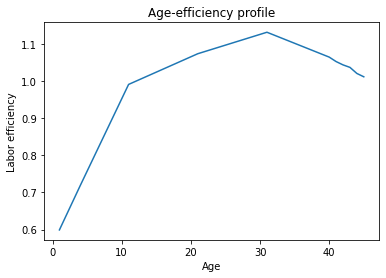

In [1]:
import numpy as np
# include OLGModel class from OLG_functions.py
from OLG_functions import OLGModel
import matplotlib.pyplot as plt

# read in ef.txt as a numpy array
ef = np.loadtxt('ef.txt', delimiter=',')

# plot ef across [1, .., len(ef)]
x = np.arange(1, len(ef)+1)
plt.plot(x, ef)
plt.xlabel('Age')
plt.ylabel('Labor efficiency')
plt.title('Age-efficiency profile')

In [25]:
OLG = OLGModel(a_max=25.0, na=250, eta=ef)

# solve HH problem
V_r, g_r, _, V_w, g_w, _, _ = OLG.V_induction()

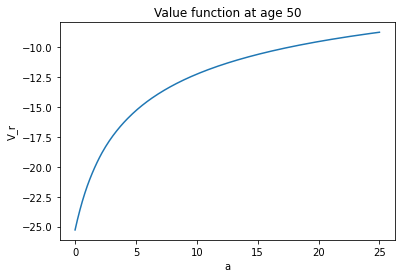

In [26]:
plt.plot(OLG.a_grid, V_r[4, :])
plt.xlabel('a')
plt.ylabel('V_r')
plt.title('Value function at age 50')
plt.show()

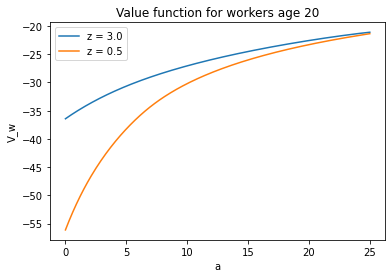

In [27]:

# Plot V_w for each value of z
for i in range(OLG.nz):
    plt.plot(OLG.a_grid, V_w[19, :, i].flatten(), label=f'z = {OLG.z_grid[i]}')
    
plt.xlabel('a')
plt.ylabel('V_w')
plt.title('Value function for workers age 20')
plt.legend()
plt.show()

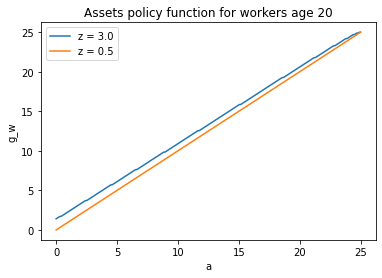

In [28]:
# Plot g_w for each value of z
for i in range(OLG.nz):
    plt.plot(OLG.a_grid, g_w[19, :, i].flatten(), label=f'z = {OLG.z_grid[i]}')
    
plt.xlabel('a')
plt.ylabel('g_w')
plt.title('Assets policy function for workers age 20')
plt.legend()
plt.show()

## Part 2

Here we solve for the stationary distribution of agents across age, productivity and wealth given the choices of households, $F_j(z, a)$. First we find the relative size of each cohort of age $j$ (denoted $\mu_j$) with 

$$ \mu_{j+1} = \frac{\mu_j}{1+n} $$ 

for each $j = 1, 2, ..., N-1$.

Then, we normalize so that $\sum_j \mu_j = 1$. Then we get the initial distribution by $F_1(z_H, 0) = \mu_1 \pi_H$, $F_1(z_L, 0) = \mu_1 \pi_L$, and then iterate forward using policy functions. Note that since retired workers are not characterized by their productivity, the distribution of retired workers is just over age and assets. 

In [29]:
F_r, F_w = OLG.steady_dist(g_r, g_w)

In [30]:
F_w[0, 0, :]

array([0.00435517, 0.01702514])

In [31]:
# proportion of workers
np.sum(F_w)

0.7639686707684433

In [32]:
# proportion of retirees
np.sum(F_r)

0.23603132923155662

Text(0.5, 1.0, 'Distribution of agents by assets')

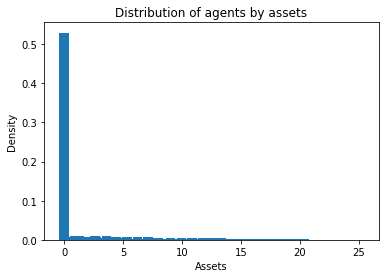

In [33]:
F_w_collapsed = np.sum(F_w, axis=(0, 2))
F_r_collapsed = np.sum(F_r, axis=0)
F_collapsed = F_w_collapsed + F_r_collapsed

# make a bar plot of the distribution of agents by assets
plt.bar(OLG.a_grid, F_collapsed)
plt.xlabel('Assets')
plt.ylabel('Density')
plt.title('Distribution of agents by assets')

---

## Part 3

Here we solve for a steady state in the benchmark model (described above). The algorithm is as follows:

1. Make initial guess for aggregates $K_0$, $L_0$
2. Solve for implied wage $w_0$ and interest rate $r_0$ using firm first order conditions
3. Use government budget constraint to solve for retirement benefits $b = \theta w_0 L_0 / \sum_{j=J^R}^N \mu_j$
4. Solve the household problem for value and policy functions given prices and retirement benefits
5. Find the implied distribution of wealth
6. Solve for the implied aggregate values $K_{new}$, $L_{new}$
7. Iterate aggregates in the direction of the new values, $K_1 = \rho K_{new} + (1-\rho) K_0$, $L_1 = \rho L_{new} + (1-\rho) L_0$ for small $\rho$
8. Take new values as the initial guess and iterate until $\max\{|K_{new} - K_0|, |L_{new} - L_0|\} < \varepsilon$

In [38]:
OLG.market_clearing(rho=.05, tol=.0005, K0=3.34, L0=.34)

K = 3.339336607154973, L = 0.3403196559794416
K = 3.3387314960643937, L = 0.3406213025078997
K = 3.3381893184908527, L = 0.3409065786696277
K = 3.3377599829544318, L = 0.34117631323839553
K = 3.337382536341941, L = 0.3414309317255921
K = 3.337052330241969, L = 0.3416714833440638
K = 3.3367973435302627, L = 0.3418988454097343
K = 3.3365901371865685, L = 0.3421137068122357
K = 3.3364612416106265, L = 0.3423169895154333
K = 3.336369896577761, L = 0.3425092139051538
K = 3.3363211499971004, L = 0.34269104296048797
K = 3.336297959113863, L = 0.34286292666899165
K = 3.336291359801713, L = 0.3430255170118447
K = 3.336308534531555, L = 0.3431792929524785
K = 3.33633076805734, L = 0.34332447767771934
K = 3.336355139543005, L = 0.3434614065581862
K = 3.3363941913002373, L = 0.3435909103762462
K = 3.3364543020801127, L = 0.343713405986011
K = 3.3365271867744624, L = 0.3438292344300038
K = 3.336604408029601, L = 0.3439384953328667
K = 3.3366871930790913, L = 0.3440417280849214
K = 3.336778612022788

(3.340399870039946,
 0.34575104718651434,
 0.024309683729806922,
 1.448085014732015,
 0.22573923721666703)

That took 14 minutes on my machine. Could do with some efficiency improvements...